# Dependency

In [1]:
import numpy as np
import scipy.io
import h5py
import matplotlib.pyplot as plt
import os
import scipy
from sklearn.cluster import KMeans

# Data Load

In [2]:
cwd = os.getcwd()
file = os.path.join(cwd,"data\DB.mat" )

In [3]:
arrays = {}
mat = h5py.File(file)
for k, v in mat.items():
    arrays[k] = np.array(v)

In [4]:
# Data 종류
print(arrays)

{'DB': array(['be2', 'be3', 'ch', 'dc3', 'ds3', 'ds4', 'ds5', 'g4', 'happy',
       'hm', 'hm2', 'iris', 'rollo2', 'sp', 'tar'], dtype='<U6')}


In [5]:
data_list = ['be2', 'be3', 'ch', 'dc3', 'ds3', 'ds4', 'ds5', 'g4', 'happy',
       'hm', 'hm2', 'iris', 'rollo2', 'sp', 'tar']

# Data Plotting

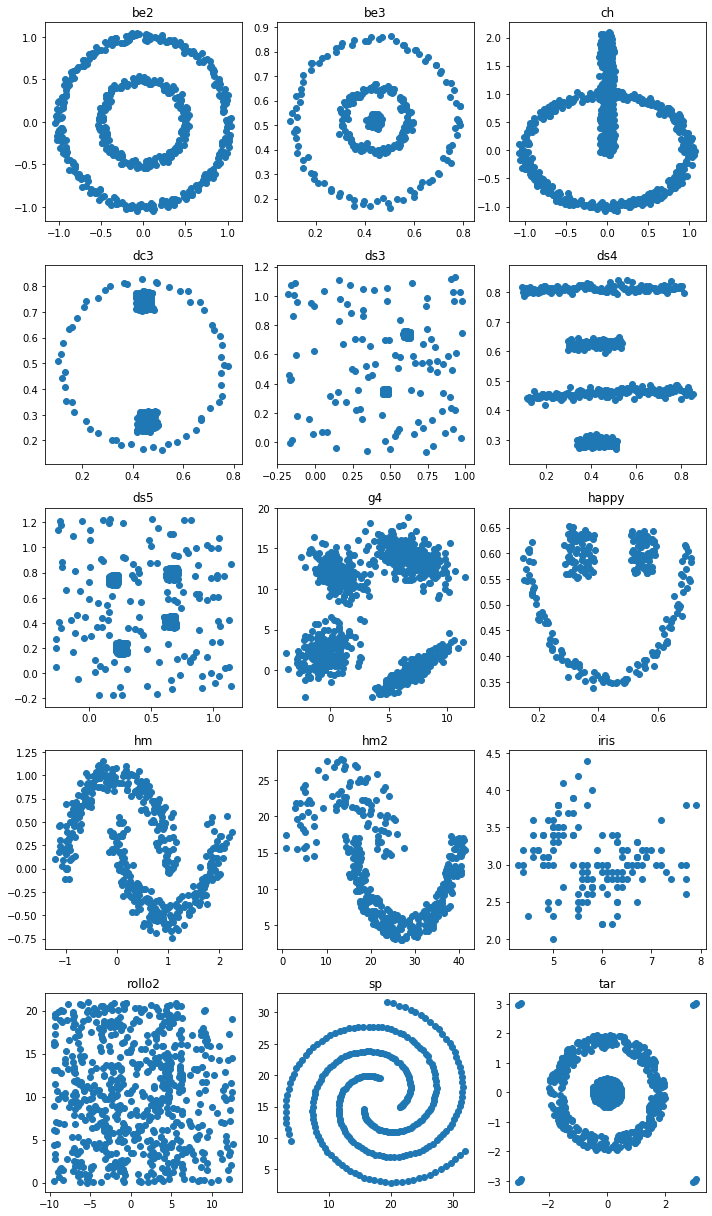

In [6]:
fig = plt.figure(figsize=(10,17))
for i,v in enumerate(data_list):
    picked_data = np.array(mat['DB/' + v]).transpose()
    ax = fig.add_subplot(5,3,i+1)
    plt.scatter(x =picked_data[:,0], y = picked_data[:,1])
    plt.title(v)
plt.tight_layout()
plt.show()

# Cluster 대상 데이터 선정

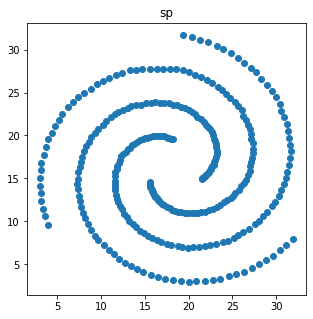

In [183]:
picked_data = np.array(mat['DB/' + 'sp']).transpose()
K = 3
plt.figure(figsize=(5,5))
plt.scatter(x =picked_data[:,0], y = picked_data[:,1])
plt.title("sp")
plt.show()

In [184]:
# Data shape
print(picked_data.shape)

(312, 2)


# Affinity Matrix 구하기

- `numpy.linalg.norm(array)` :: vector의 길이를 계산해줌
- 가우시안 커널 통과

In [185]:
# Data Length
N = picked_data.shape[0]

In [186]:
Affinity = np.zeros((N,N))

In [187]:
print(Affinity.shape)

(312, 312)


`np.linalg.norm(array)` : vector 길이를 계산해 준다.  
  
ex )  
```
a = np.array([1, 2])  
np.linalg.norm(a)  
```

In [188]:
# sig1과 sig2를 다르게 하여 조정
def gaussian_kernel(x1, x2, sig1=0.8, sig2=1):
    return np.exp(-np.linalg.norm(x1-x2)**2/(2*sig1*sig2))

In [189]:
# 가우시안 커널을 통과 시켜 데이터 채우기 : -> Affinity Matrix
for i in range(N):
    for j in range(N):
        Affinity[i][j] = squared_exponential(picked_data[i],picked_data[j])

In [190]:
print(Affinity)

[[1.00000000e+00 5.14755885e-01 8.52216304e-02 ... 1.28667673e-83
  1.72777648e-84 7.57172114e-85]
 [5.14755885e-01 1.00000000e+00 5.65348740e-01 ... 4.75363623e-79
  5.20988321e-80 2.10498310e-80]
 [8.52216304e-02 5.65348740e-01 1.00000000e+00 ... 7.36299712e-76
  6.58628634e-77 2.45343642e-77]
 ...
 [1.28667673e-83 4.75363623e-79 7.36299712e-76 ... 1.00000000e+00
  9.61690602e-01 9.26295019e-01]
 [1.72777648e-84 5.20988321e-80 6.58628634e-77 ... 9.61690602e-01
  1.00000000e+00 9.93769491e-01]
 [7.57172114e-85 2.10498310e-80 2.45343642e-77 ... 9.26295019e-01
  9.93769491e-01 1.00000000e+00]]


## Laplacian Matrix

1. 대각행렬을 구한다

2. ```L = D^{-1/2} A D{-1/2}```  
 --> Computes the symetric normalized laplacian.(대칭 정규화된 그래프 라플라시안)





In [191]:
# 대각행렬
D = np.zeros(Affinity.shape)

In [192]:
W = np.sum(Affinity, axis=0)

In [193]:
# len(temp) 씩 건너뛰어 값 삽입
D.flat[::len(W) +1] = W ** (-0.5)

In [194]:
# 대칭정규화된 그래프 라플라시안
L = D.dot(Affinity).dot(D)

# Eigen Vector 구하기

`scipy.sparse.linalg.eigs` : Lanczos 알고리즘 :: case of symmetric matrices

In [195]:
import scipy.sparse.linalg as sp

In [196]:
# Eigen Value와 Eigen Vector 구하기
eig_val, eig_vect = sp.eigs(L, K)
X = eig_vect.real

**L2_Norm** 

`np.linalg.norm(x, ord=None, axis=None, keepdims=False)`  
`x`: vector  
`ord`: 차수  
`axis`: 연산 방향 (0, 1)  
`keepdims`: 출력을 x와 동일한 차원(dim) 유지  

`np.linalg.norm([[1,2,3],[1,2,3]], ord=2, axis=1)`   

> array([3.74165739, 3.74165739])

In [197]:
#2-norm (largest sing. value) 제곱해서 더함
rows_norm = np.linalg.norm(X, axis=1, ord=2)

**Eig_Vector / L2_norm**

In [198]:
Y = (X.T / rows_norm).T

# Visualization

In [199]:
import seaborn
from itertools import cycle, islice

In [200]:
def k_means(X, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=1231)
    return kmeans.fit(X).labels_

In [201]:
labels = k_means(Y, K)

 - `islice()` : cycle('ABCD') --> A B C D A B C D ...
 - `cycle()` : islice('ABCDEFG', 2, None) --> C D E F G

In [202]:
colors = np.array(list(islice(cycle(seaborn.color_palette()), int(max(labels) + 1))))

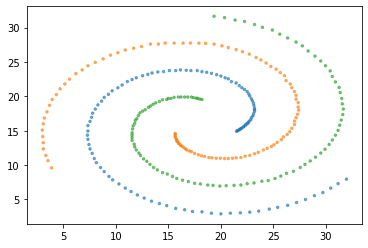

In [203]:
plt.scatter(picked_data[:, 0], picked_data[:, 1], color=colors[labels], s=6, alpha=0.6)

In [126]:
def com_aff_local_scaling(picked_data):
    N = X.shape[0]
    ans = np.zeros((N, N))
    sig = []
    for i in range(N):
        dists = []
        for j in range(N):
            dists.append(np.linalg.norm(X[i] - X[j]))
        dists.sort()
        sig.append(np.mean(dists[:5]))

    for i in range(N):
        for j in range(N):
            ans[i][j] = gaussian_kernel(X[i], X[j], sig[i], sig[j])
    return ans

In [127]:
com_aff_local_scaling(picked_data)

array([[1.00000000e+00, 3.92439697e-15, 2.25871061e-27, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.92439697e-15, 1.00000000e+00, 8.64822393e-05, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.25871061e-27, 8.64822393e-05, 1.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.00000000e+00, 2.85170797e-44],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 2.85170797e-44, 1.00000000e+00]])